## Single Shot Detector

SDD convolutional neural network implementation for object detection from scratch

Import libraries and download dataset

In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


5717

In [ ]:
classes = ["background","aeroplane","bicycle","bird","boat",
"bottle","bus","car","cat","chair","cow","diningtable","dog",
"horse","motorbike","person","pottedplant","sheep","sofa",
"train","tvmonitor"]

The following functions help us extract the information we need from the annotations and display samples from the dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
    img, label = train[ix]
    img_np = np.array(img)
    anns = label['annotation']['object']
    if type(anns) is not list:
        anns = [anns]
    labels = np.array([classes.index(ann['name']) for ann in anns])
    bbs = [ann['bndbox'] for ann in anns]
    bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax']),int(bb['ymax'])] for bb in bbs])
    anns = (labels, bbs)
    return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
    # anns is a tuple with (labels, bbs)
    # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
    # labels is an array containing the label 
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    labels, bbs = anns
    for lab, bb in zip(labels, bbs):
        if bg == -1 or lab != bg:
            x, y, xm, ym = bb
            w, h = xm - x, ym - y
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
            text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
            ax.add_patch(rect)

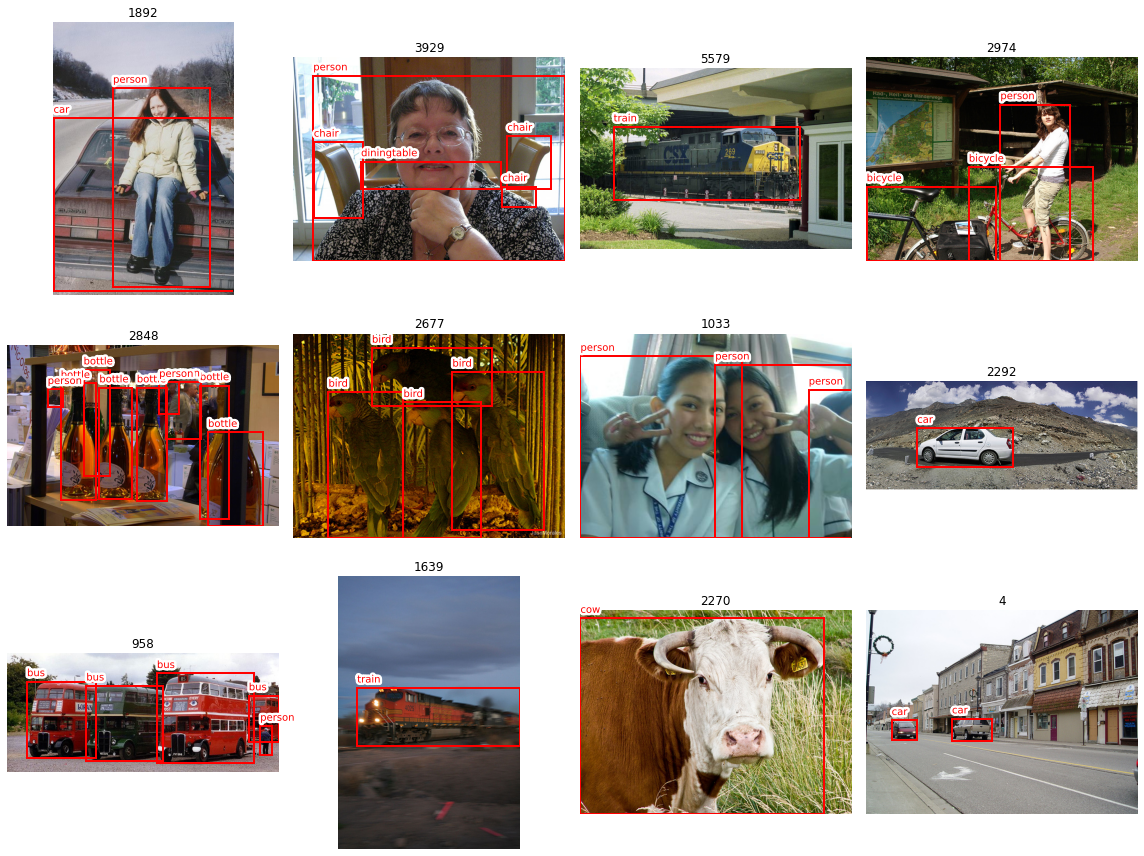

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

## Box Proposal

In [ ]:
def norm(bb, shape):
    # normalize bb
    # shape = (heigh, width)
    # bb = [x_min, y_min, x_max, y_max]
    h, w = shape
    return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
    # unnormalize bb
    # shape = (heigh, width)
    # bb = [x_min, y_min, x_max, y_max]
    h, w = shape
    return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):
    return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)

#def xywh2xyxy(bb):
#  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

def generate_anchors(scales, centers, sizes):
    k, anchors, grid_size = [], [], []
    for s in scales:
        cnt = 0
        for (x, y) in centers:
            for (w, h) in sizes:
                for i in range(s):
                    for j in range(s):
                        # cwh
                        #anchors.append(np.array([x+i, y+j, w, h])/s)
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
                        grid_size.append(np.array([1./s,1./s]))
                cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

We give the "generate_anchors" function a list of different scales at which we want to have detections, another one with the center of the boxes, the scale and the *aspect ratio*. The function returns a list with all the boxes that the model will take into account during training to detect objects in them.

In [ ]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
    # anns is a tuple with (bbs, labels)
    # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
    # labels is an array containing the label 
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    labels, bbs = anns

    anchors = xyxy2xywh(anchors)
    _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
    for a in _anchors:
        x, y, w, h = a
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)

    labels, bbs = anns
    for lab, bb in zip(labels, bbs):
        x, y, xm, ym = bb
        w, h = xm - x, ym - y
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
        text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        ax.add_patch(rect)

(138, [3, 3, 3])

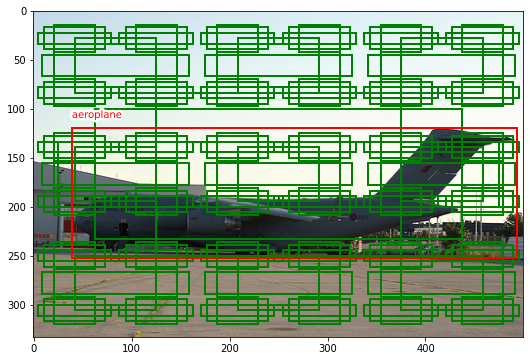

In [ ]:
ix = 4445
img_np, anns = get_sample(ix)
labels, bbs = anns

scales = [6, 3, 1]               
centers = [(0.5, 0.5)] 
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

plot_anchors(img_np, anns, anchors)
len(anchors), k

The efficiency and precision of the model will depend on the number of boxes that we propose, many boxes will give us a slow model, but potentially more accurate.

If in our application we know well the scale and size of the objects we want to detect, putting only boxes at those scales will result in a precise and efficient model.

## Model

We will create a backbone that extracts features from the image and then several heads that produce the classifications and offsets on the proposed boxes, these heads are fed with the outputs of different convolutional layers of the backbone, thus allowing detection at multiple scales, these scales must coincide with those defined when generating our box proposals

In [ ]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

class SSD(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
        super().__init__()
        # backbone
        self.conv1 = block(n_channels, 8)
        self.conv2 = block(8, 16)
        self.conv3 = block(16, 32)
        self.conv4 = block(32, 64)
        self.conv5 = block(64, 64)
        self.conv6 = block(64, 64)
        # head
        self.k = k
        self.out4 = out_conv(64, self.k[0], n_classes)
        self.out5 = out_conv(64, self.k[1], n_classes)
        self.out6 = out_conv(64, self.k[2], n_classes)

    def forward(self, x):
        # backbone
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)     # for inputs de 100x100
        x4 = self.conv4(x)    # 6x6
        x5 = self.conv5(x4)   # 3x3
        x6 = self.conv6(x5)   # 1x1

        # head
        o1l, o1c = self.out4(x4)
        o2l, o2c = self.out5(x5)
        o3l, o3c = self.out6(x6)
        return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)    
        #return o2l, o2c

In [ ]:
net = SSD(n_classes=len(classes), k=k)
output = net(torch.rand((64,3,100,100)))
output[0].shape, output[1].shape

(torch.Size([64, 138, 4]), torch.Size([64, 138, 21]))

## Loss Function

During training, the model will give us 4 values for each of the proposed boxes (offests) as well as the 21 probabilities assigned to each class, first we have to take the outputs of the model and calculate the offsets. With the tanh function, we limit the outputs to values in the range (-1, 1), allowing an offset of up to 50% of the box sizes in both dimensions.

In [ ]:
def actn_to_bb(actn, anchors, grid_size):
    actn_bbs = torch.tanh(actn)
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5
    return torch.cat([actn_p1, actn_p2], dim=1)

Each image has an indeterminate number of detections, so first we have to match the proposed boxes with those annotations with which they best match, a metric known as IoU (intersection over unions) will be used.

Once this value has been calculated for each proposed box with respect to all the boxes in the labels, we are left with those that exceed a certain threshold (by default 0.4).

In [ ]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

Usamos una combinación de L1Loss y CrossEntropyLoss para la localización y clasificación, respectivamente

In [ ]:
class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()
        self.loc_loss = torch.nn.L1Loss()
        self.class_loss = torch.nn.CrossEntropyLoss()
        self.anchors = anchors.to(device)
        self.grid_size = grid_size.to(device)
        self.threshold = threshold

    def forward(self, preds, target):
        pred_bbs, pred_cs = preds 
        tar_bbs, c_t = target # B x O x 4, B x O
        # each image in the batch can have a different number of detections
        loc_loss, clas_loss = 0, 0
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            labels = torch.zeros(len(self.anchors)).long().to(device) # by default all tags are `background`
            if tar_bb.shape[0] is not 0: # there may be images without detections
                # we calculate the IoU of the detections with the boxes
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)
                # we keep those that match
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)
                pos = gt_overlap > self.threshold
                # we optimize for those boxes that pass the filter
                pos_idx = torch.nonzero(pos)[:,0]
                tar_idx = gt_idx[pos_idx]
                pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)
                _anchors = pred_bb[pos_idx]
                tar_bb = tar_bb[tar_idx]
                loc_loss += self.loc_loss(_anchors, tar_bb)
                labels[pos_idx] = tar_c[tar_idx]
                clas_loss += self.class_loss(pred_c, labels)
        return clas_loss + loc_loss

## Training

The fit will be made from a single image to simplify things for now

In [ ]:
def fit(model, X, target, epochs=1, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss_loc.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")

The grid and the boxes will work with 100 x 100 pixel images, we use albumentations to do the image resize and annotations

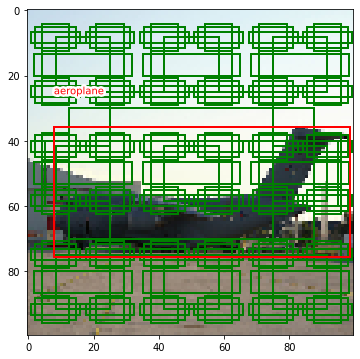

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(100, 100)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [ ]:
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0).to(device)
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

img_tensor.shape, bb_tensor.shape, label_tensor.shape

(torch.Size([1, 3, 100, 100]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [ ]:
model = SSD(n_classes = len(classes), k=k)
fit(model, img_tensor, (bb_tensor, label_tensor), epochs=100)

Epoch 1/100 loss 3.13668
Epoch 2/100 loss 3.12862
Epoch 3/100 loss 3.12046
Epoch 4/100 loss 3.11204
Epoch 5/100 loss 3.10330
Epoch 6/100 loss 3.09408
Epoch 7/100 loss 3.08415
Epoch 8/100 loss 3.07333
Epoch 9/100 loss 3.06147
Epoch 10/100 loss 3.04836
Epoch 11/100 loss 3.03377
Epoch 12/100 loss 3.01741
Epoch 13/100 loss 2.99901
Epoch 14/100 loss 2.97830
Epoch 15/100 loss 2.95485
Epoch 16/100 loss 2.92825
Epoch 17/100 loss 2.89793
Epoch 18/100 loss 2.86347
Epoch 19/100 loss 2.82460
Epoch 20/100 loss 2.78009
Epoch 21/100 loss 2.72895
Epoch 22/100 loss 2.67011
Epoch 23/100 loss 2.60480
Epoch 24/100 loss 2.53280
Epoch 25/100 loss 2.45306
Epoch 26/100 loss 2.36534
Epoch 27/100 loss 2.26962
Epoch 28/100 loss 2.16695
Epoch 29/100 loss 2.05115
Epoch 30/100 loss 1.92312
Epoch 31/100 loss 1.78278
Epoch 32/100 loss 1.63410
Epoch 33/100 loss 1.48098
Epoch 34/100 loss 1.32609
Epoch 35/100 loss 1.17166
Epoch 36/100 loss 1.01884
Epoch 37/100 loss 0.87396
Epoch 38/100 loss 0.73795
Epoch 39/100 loss 0.6

## Generating predictions

In [ ]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

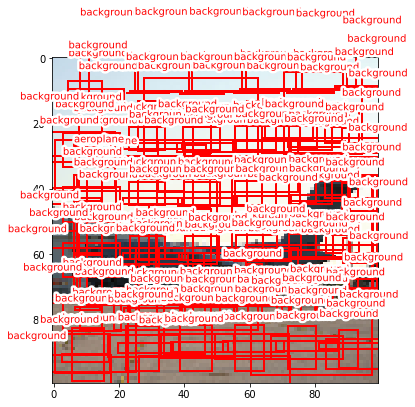

In [ ]:
plot_anns(img, (labels, bbs))
plt.show()

There are as many predictions as there are proposed boxes, most of them by default will have the background class assigned, so we discard all these boxes.

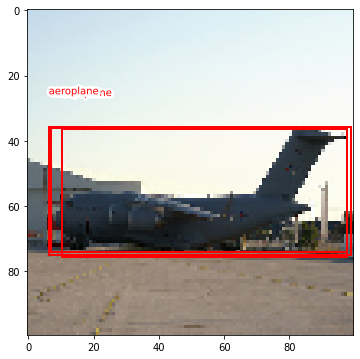

In [ ]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

It is possible that we have several detections for the same object, we apply the NMS (non maximum suppression) algorithm that calculates the IoU of detections with the same class and, if this value is above a certain threshold, returns only the detection with the highest probability.

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
# remove bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

(tensor([[0.0702, 0.3613, 0.9770, 0.7418],
         [0.1023, 0.3629, 0.9761, 0.7569],
         [0.0619, 0.3576, 0.9900, 0.7513]]),
 tensor([1, 1, 1]),
 tensor([0.9723, 0.9533, 0.9780]))

In [ ]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs

tensor([2])

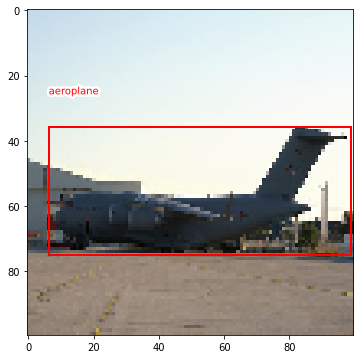

In [ ]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()